# Resampling



## 0.환경준비

### 0.1 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.2 데이터 로딩

> 예제 데이터는 반도체 공정간 불량을 예측하는 데이터입니다.  
여기서는 class imbalance 에 대한 샘플링과 성능에만 초점을 맞추겠습니다.


In [2]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)

## 1.데이터 탐색


* 데이터의 크기를 살펴봅시다.

In [3]:
data.shape

(1150, 17)

In [4]:
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


In [5]:
target = 'Attrition'

0    1050
1     100
Name: Attrition, dtype: int64


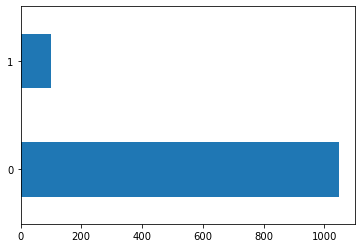

In [6]:
print(data[target].value_counts())

data[target].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 2.1 x, y로 나누기 

In [7]:
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2.2 가변수화

In [8]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

### 2.3 train : validation 분할

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2022)

In [11]:
x_train.shape

(805, 38)

## 3.모델링 with Resampling

In [12]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

### 3.1 기본 모델링

* 로지스틱 회귀 + 데이터 그대로 이용

In [16]:
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[321   2]
 [ 19   3]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       323
           1       0.60      0.14      0.22        22

    accuracy                           0.94       345
   macro avg       0.77      0.57      0.60       345
weighted avg       0.92      0.94      0.92       345



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
* 이전 버전 solver = 'liblinear'
* 최근 버전 solver = 'lbfgs' (max_iter 옵션 경고 문구들이 발생)

In [17]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[321   2]
 [ 20   2]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       323
           1       0.50      0.09      0.15        22

    accuracy                           0.94       345
   macro avg       0.72      0.54      0.56       345
weighted avg       0.91      0.94      0.92       345



### 3.2 모델링 with Resampling

* Down Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [19]:
# down sampling
down_sample = RandomUnderSampler()
d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)

print(np.bincount(d_y_train))
print(np.bincount(d_y_train) / d_y_train.shape[0])

model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

[78 78]
[0.5 0.5]
0.23312883435582823
-------------------------------------------------------
[[201 122]
 [  3  19]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       323
           1       0.13      0.86      0.23        22

    accuracy                           0.64       345
   macro avg       0.56      0.74      0.50       345
weighted avg       0.93      0.64      0.73       345



* Up Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [20]:
# up sampling
up_sample = RandomOverSampler()
u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)

print(np.bincount(u_y_train))
print(np.bincount(u_y_train) / u_y_train.shape[0])

model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

[727 727]
[0.5 0.5]
0.26153846153846155
-------------------------------------------------------
[[232  91]
 [  5  17]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       323
           1       0.16      0.77      0.26        22

    accuracy                           0.72       345
   macro avg       0.57      0.75      0.55       345
weighted avg       0.93      0.72      0.79       345



* SMOTE Sampling + 로지스틱 회귀
    * Resamlpling
    * 모델링
    * 평가 : confusion_matrix, classification_report

In [21]:
# SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(s_y_train))
print(np.bincount(s_y_train) / s_y_train.shape[0])

model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(s_x_train, s_y_train)
pred_s = model_u.predict(x_val)

print(f1_score(y_val,pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

[727 727]
[0.5 0.5]
0.26153846153846155
-------------------------------------------------------
[[232  91]
 [  5  17]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       323
           1       0.16      0.77      0.26        22

    accuracy                           0.72       345
   macro avg       0.57      0.75      0.55       345
weighted avg       0.93      0.72      0.79       345



### 3.3 각 resampling 기법별로 성능을 비교해 봅시다.
여러번 반복실행한 다음 f1 score 성능 비교


In [22]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [24]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

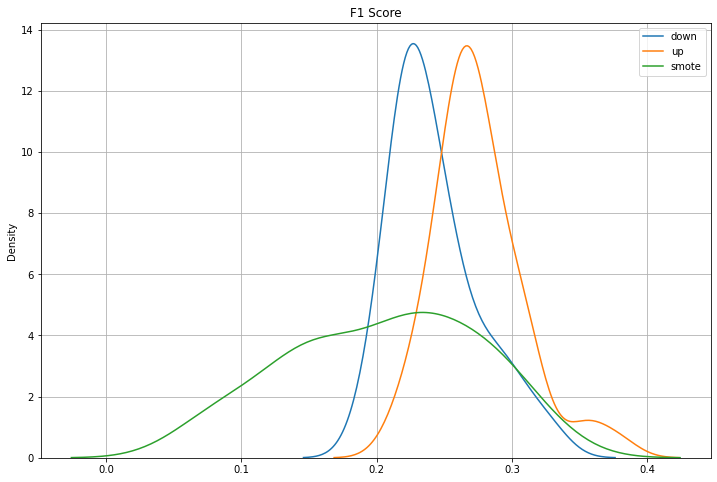

In [25]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label = 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()


## 4.실습 : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다. 
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### 4.1 데이터 준비

* 데이터 로딩

In [26]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [27]:
target = 'label'

In [28]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [29]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable  
모두 숫자 데이터이므로 가변수화 대상은 없습니다.


* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [32]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


### 4.2 기본모델링
> * 알고리즘은 로지스틱 회귀를 이용합시다.
* 데이터셋을 그대로 모델링을 수행하시오.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import * 

In [34]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-'*54)
print(classification_report(y_val, pred))

[[295   1]
 [ 18   0]]
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       296
           1       0.00      0.00      0.00        18

    accuracy                           0.94       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.89      0.94      0.91       314



### 4.3 모델링 with Resampling
> * down, up, smote 샘플링후 각각 데이터를 이용하여 모델링 하시오.
* 알고리즘 : 기존 샘플과 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [35]:
# down sampling
down = RandomUnderSampler()

d_x_train, d_y_train = down.fit_resample(x, y)

print(np.bincount(d_y_train))
print(np.bincount(d_y_train) / d_y_train.shape[0])

model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(confusion_matrix(y_val, pred_d))
print('-'*52)
print(classification_report(y_val, pred_d))

[104 104]
[0.5 0.5]
[[166 130]
 [  7  11]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.56      0.71       296
           1       0.08      0.61      0.14        18

    accuracy                           0.56       314
   macro avg       0.52      0.59      0.42       314
weighted avg       0.91      0.56      0.68       314



In [37]:
# up sampling
up = RandomOverSampler()

u_x_train, u_y_train = up.fit_resample(x, y)

print(np.bincount(u_y_train))
print(np.bincount(u_y_train) / u_y_train.shape[0])

model_u = LogisticRegression(solver='liblinear')
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(confusion_matrix(y_val, pred_u))
print('-'*52)
print(classification_report(y_val, pred_u))

[1463 1463]
[0.5 0.5]
[[190 106]
 [  5  13]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.64      0.77       296
           1       0.11      0.72      0.19        18

    accuracy                           0.65       314
   macro avg       0.54      0.68      0.48       314
weighted avg       0.92      0.65      0.74       314



In [38]:
# SMOTE
smote = SMOTE()

s_x_train, s_y_train = smote.fit_resample(x,y)

print(np.bincount(s_y_train))
print(np.bincount(s_y_train) / s_y_train.shape[0])

model_s = LogisticRegression(solver='liblinear')
model_s.fit(s_x_train, s_y_train)
pred_s = model_s.predict(x_val)

print(confusion_matrix(y_val, pred_s))
print('-'*52)
print(classification_report(y_val, pred_s))

[1463 1463]
[0.5 0.5]
[[199  97]
 [  6  12]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       296
           1       0.11      0.67      0.19        18

    accuracy                           0.67       314
   macro avg       0.54      0.67      0.49       314
weighted avg       0.92      0.67      0.76       314



* 모델링

* 로지스틱 회귀- 여러번 반복 실행

3.3의 코드를 붙여놓고 실행해 봅시다.

In [39]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver='liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val, pred, pos_label=1)

In [40]:
d_result, u_result, s_result = [], [], []

for i in range(100) :
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    down = RandomUnderSampler()
    up = RandomOverSampler()
    smote = SMOTE()
    
    d_x_tr, d_y_tr = down.fit_resample(x_train, y_train)
    u_x_tr, u_y_tr = up.fit_resample(x_train, y_train)
    s_x_tr, s_y_tr = smote.fit_resample(x_train, y_train)
    
    d_result.append(lr_modeling(d_x_tr, d_y_tr, x_val, y_val))
    u_result.append(lr_modeling(u_x_tr, u_y_tr, x_val, y_val))
    s_result.append(lr_modeling(s_x_tr, s_y_tr, x_val, y_val))
    
    print(i, end = ' ')


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 

C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

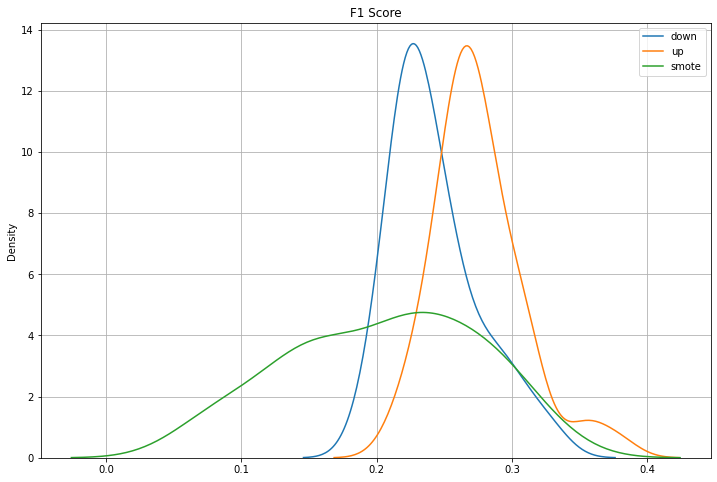

In [41]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label = 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()